# Week 2

As explained in Lecture 1, each week of this class is a Jupyter notebook like this one. In order to follow the class, you simply start reading from the top, following the instructions.

## Today

This lecture covers:

1. **Principles of good visualization**: We'll watch a video on what makes plots effective and create your own checklist.
2. **Merging messy real-world datasets**: You'll combine SF crime data from two different time periods (2003-2018 and 2018-present) that use different schemas and categories. This is one of the most common and frustrating tasks in data science.
3. **Temporal pattern analysis**: Using your merged 20+ year dataset, you'll explore crime patterns across years, months, weekdays, and hours.
4. **Advanced visualization techniques**: You'll experiment with calendar plots, polar charts, and time series visualizations.

By the end, you'll have a unified crime dataset spanning two decades and the skills to wrangle similarly messy data in your future work.

## Part 1: Creating nice plots

Ok. There's a lot of barcharts today. We need them ... they are a fantastic tool for data exploration. But it can get monotonous, so let's take a little break to talk about something else before digging deeper with the barcharts.

I want to tell you a bit about how to make nice plots. I do that in the video below

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('9hIu4pgJXQc', width=800, height=450)

: 

> **Exercise 1.1**: Nice plots
>
> * Create a list of 10 rules for nice plots based on the video.

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> Answer in your own words, do your own research, don't use your LLM. Once you've written down your answers, it's OK to use the LLM to refine your writing.
</div>

## Part 2: Merging Historical and Recent Crime Data

So far we've been working with crime data from 2018 onwards (I will assume you have that file, named something like "Police Department Incident Reports 2018 to Present"). But San Francisco has published crime data going all the way back to 2003! Having access to this longer time series would let us:
- Study long-term trends in crime
- See how crime patterns changed before, during, and after major events
- Have more statistical power for our analyses

The catch? **The two datasets don't have the same structure.** This is an incredibly common situation in data science. Organizations change how they record data over time, different departments use different formats, and merging datasets requires careful thought.

### Why This Matters

In the real world, you'll almost never get a single, clean dataset that answers your question. Instead, you'll need to combine data from multiple sources: different time periods, different departments, different organizations. Each source will have its own quirks, naming conventions, and missing values.

This is also directly relevant to algorithmic accountability. Remember the Richardson et al. reading from Week 1? They argued that "dirty data" undermines predictive policing. But what counts as "dirty"? If crime categories change over time—if `DRUNKENNESS` disappears as a category in 2018—does that mean public intoxication stopped? Or just that we can't track it anymore? These are the kinds of questions you need to ask whenever you merge datasets.

The skills you'll practice here—schema mapping, category matching, validation—are foundational for any serious data work.

### Step 2.1: Understand both schemas

> **Mini Exercise**: Schema exploration
>
> Download the historical dataset "Police Department Incident Reports: Historical 2003 to May 2018" from SF OpenData (or use the file provided).
>
> * Load both datasets and examine their columns
> * Which columns appear in both datasets (perhaps with different names)?
> * Which columns are unique to each dataset?
> * Create a "mapping" showing which columns in the historical data correspond to which columns in the recent data

Here's a starter to help you think about the mapping:

| Information | Historical Column | Recent Column |
|-------------|------------------|---------------|
| Crime type | `Category` | `Incident Category` |
| Police district | `PdDistrict` | `Police District` |
| Date | `Date` | `Incident Date` |
| ... | ... | ... |

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> You should be able to do this no problem in pandas, but if you find it tough, feel free to ask an LLM for help.
</div>

In [7]:
# --- Step 2.1: The Category Problem ---

import pandas as pd

# Load recent dataset (from Week 1 cleaning step if already loaded)
recent_path = "../../dataset/Week1/Police_Department_Incident_Reports__2018_to_Present_20260203.csv"
historical_path = "../../dataset/Week2/Police_Department_Incident_Reports__Historical_2003_to_May_2018_20260212.csv"

df_recent = pd.read_csv(recent_path, nrows=5)
df_historical = pd.read_csv(historical_path, nrows=5)

# Examine columns
recent_cols = set(df_recent.columns)
historical_cols = set(df_historical.columns)

common_cols = recent_cols.intersection(historical_cols)
recent_only = recent_cols - historical_cols
historical_only = historical_cols - recent_cols

print("Common columns:\n", sorted(common_cols))
print("\nRecent-only columns:\n", sorted(recent_only))
print("\nHistorical-only columns:\n", sorted(historical_only))

# Manual mapping based on schema inspection
column_mapping = {
    "Category": "Incident Category",
    "Descript": "Incident Description",
    "PdDistrict": "Police District",
    "Date": "Incident Date",
    "Time": "Incident Time",
    "X": "Longitude",
    "Y": "Latitude",
    "Resolution": "Resolution",
    "Address": "Intersection / Address",
}

mapping_df = pd.DataFrame(
    column_mapping.items(),
    columns=["Historical Column", "Recent Column"]
)

mapping_df


Common columns:
 ['Incident Code', 'Resolution', 'data_loaded_at']

Recent-only columns:
 ['Analysis Neighborhood', 'CAD Number', 'CNN', 'Filed Online', 'Incident Category', 'Incident Date', 'Incident Datetime', 'Incident Day of Week', 'Incident Description', 'Incident ID', 'Incident Number', 'Incident Subcategory', 'Incident Time', 'Incident Year', 'Intersection', 'Latitude', 'Longitude', 'Point', 'Police District', 'Report Datetime', 'Report Type Code', 'Report Type Description', 'Row ID', 'Supervisor District', 'Supervisor District 2012', 'data_as_of']

Historical-only columns:
 ['Address', 'Category', 'Date', 'DayOfWeek', 'Descript', 'IncidntNum', 'PdDistrict', 'PdId', 'Time', 'X', 'Y', 'location']


,Historical Column,Recent Column
0,Category,Incident Category
1,Descript,Incident Description
2,PdDistrict,Police District
3,Date,Incident Date
4,Time,Incident Time
5,X,Longitude
6,Y,Latitude
7,Resolution,Resolution
8,Address,Intersection / Address


## Step 2.2: Identify the common ground

> **Mini Exercise**: Essential columns
>
> * For the analyses we've have been doing (crime categories, time patterns, police districts), and *will be doing in future lectures* (**mapping GPS points**) which columns do we need?
> * Make a list of the essential/potentially interesting columns and their names in each dataset
> * Check the data types — are dates stored the same way? Are coordinates in the same format?
> * Handle any format differences (hint: look carefully at how dates are formatted in each file)

In [10]:
# --- Step 2.2: The Category Problem ---

import pandas as pd

# Load recent dataset (from Week 1 cleaning step if already loaded)
recent_path = "../../dataset/Week1/Police_Department_Incident_Reports__2018_to_Present_20260203.csv"
historical_path = "../../dataset/Week2/Police_Department_Incident_Reports__Historical_2003_to_May_2018_20260212.csv"

# Load small samples to inspect schema + dtypes
df_recent = pd.read_csv(recent_path, nrows=1000)
df_historical = pd.read_csv(historical_path, nrows=1000)

# Essential columns for analysis
# Crime type
# Time (date/datetime)
# Police district
# Coordinates (lat/lon)

essential_recent = [
    "Incident Category",
    "Incident Datetime",   # or Incident Date + Incident Time
    "Police District",
    "Latitude",
    "Longitude",
]

essential_historical = [
    "Category",
    "Date",
    "Time",
    "PdDistrict",
    "Y",   # Latitude
    "X",   # Longitude
]

print("Recent dtypes:\n", df_recent[essential_recent].dtypes)
print("\nHistorical dtypes:\n", df_historical[essential_historical].dtypes)

# Handle date format differences 
# Recent: already combined datetime
df_recent["Incident Datetime"] = pd.to_datetime(
    df_recent["Incident Datetime"],
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# Historical: Date + Time are separate → combine
df_historical["Incident Datetime"] = pd.to_datetime(
    df_historical["Date"] + " " + df_historical["Time"],
    errors="coerce"
)

# Rename columns to align schemas
df_historical = df_historical.rename(columns={
    "Category": "Incident Category",
    "PdDistrict": "Police District",
    "X": "Longitude",
    "Y": "Latitude"
})

# Keep aligned essential columns
df_recent_clean = df_recent[[
    "Incident Category",
    "Incident Datetime",
    "Police District",
    "Latitude",
    "Longitude"
]]

df_historical_clean = df_historical[[
    "Incident Category",
    "Incident Datetime",
    "Police District",
    "Latitude",
    "Longitude"
]]

print("\nRecent cleaned dtypes:\n", df_recent_clean.dtypes)
print("\nHistorical cleaned dtypes:\n", df_historical_clean.dtypes)


Recent dtypes:
 Incident Category        str
Incident Datetime        str
Police District          str
Latitude             float64
Longitude            float64
dtype: object

Historical dtypes:
 Category          str
Date              str
Time              str
PdDistrict        str
Y             float64
X             float64
dtype: object

Recent cleaned dtypes:
 Incident Category              str
Incident Datetime    datetime64[s]
Police District                str
Latitude                   float64
Longitude                  float64
dtype: object

Historical cleaned dtypes:
 Incident Category               str
Incident Datetime    datetime64[us]
Police District                 str
Latitude                    float64
Longitude                   float64
dtype: object


### Step 2.3: The Category Problem

This is where things get tricky (but interesting). The crime categories in the two datasets are **not the same**.

> **Mini Exercise**: Explore the category differences
>
> * List all unique categories in each dataset
> * How many categories are in the historical data? How many in the recent data?
> * Which categories appear to match (even if the names are slightly different)?
> * Which categories exist in one dataset but not the other?

In [12]:
# --- Step 2.3: The Category Problem ---

import pandas as pd

# Load recent dataset (from Week 1 cleaning step if already loaded)
recent_path = "../../dataset/Week1/Police_Department_Incident_Reports__2018_to_Present_20260203.csv"
historical_path = "../../dataset/Week2/Police_Department_Incident_Reports__Historical_2003_to_May_2018_20260212.csv"

# Load only necessary columns to keep it light
df_recent = pd.read_csv(recent_path, usecols=["Incident Category"])
df_historical = pd.read_csv(historical_path, usecols=["Category"])

# Unique categories
recent_categories = sorted(df_recent["Incident Category"].dropna().unique())
historical_categories = sorted(df_historical["Category"].dropna().unique())

# Counts
num_recent = len(recent_categories)
num_historical = len(historical_categories)

print("Number of recent categories:", num_recent)
print("Number of historical categories:", num_historical)

# Convert to sets for comparison
recent_set = set(cat.lower() for cat in recent_categories)
historical_set = set(cat.lower() for cat in historical_categories)

# Exact matches
exact_matches = sorted(recent_set & historical_set)

# Categories only in one dataset
recent_only = sorted(recent_set - historical_set)
historical_only = sorted(historical_set - recent_set)

print("\nExact matches:")
print(exact_matches)

print("\nOnly in recent dataset:")
print(recent_only)

print("\nOnly in historical dataset:")
print(historical_only)


Number of recent categories: 49
Number of historical categories: 37

Exact matches:
['arson', 'assault', 'burglary', 'disorderly conduct', 'embezzlement', 'fraud', 'gambling', 'liquor laws', 'missing person', 'non-criminal', 'other offenses', 'prostitution', 'recovered vehicle', 'robbery', 'stolen property', 'suicide', 'suspicious occ', 'vandalism']

Only in recent dataset:
['case closure', 'civil sidewalks', 'courtesy report', 'drug offense', 'drug violation', 'fire report', 'forgery and counterfeiting', 'homicide', 'human trafficking (a), commercial sex acts', 'human trafficking (b), involuntary servitude', 'human trafficking, commercial sex acts', 'larceny theft', 'lost property', 'malicious mischief', 'miscellaneous investigation', 'motor vehicle theft', 'motor vehicle theft?', 'offences against the family and children', 'other', 'other miscellaneous', 'rape', 'sex offense', 'suspicious', 'traffic collision', 'traffic violation arrest', 'vehicle impounded', 'vehicle misplaced', 'wa

### Intermezzo: The many flavors of category mismatch

Here are some concrete problems you'll discover:

**Problem 1: Case and formatting differences**

The historical data uses ALL CAPS (`ASSAULT`, `BURGLARY`) while the recent data uses Title Case (`Assault`, `Burglary`). This is easy to fix with `.str.upper()` or `.str.lower()`.

**Problem 2: Name changes**

Some categories look like they were simply renamed:
- `VEHICLE THEFT` → `Motor Vehicle Theft`

**Problem 3: Categories that split or merged**

This is trickier. For example:
- The historical `SEX OFFENSES` might correspond to multiple recent categories: `Sex Offense`, `Rape`, `Human Trafficking`
- The recent data has both `Drug Offense` and `Drug Violation` — should these both map to the historical `DRUG/NARCOTIC`?
- `VANDALISM` in historical data — is that `Vandalism` or `Malicious Mischief` in the recent data? Or both?

**Problem 4: Categories that disappeared or appeared**
- `DRUNKENNESS` exists in historical data but not in recent — was it merged into something else? Decriminalized? Maybe Google it or ask an LLM.
- `Traffic Collision` exists in recent data but not historical — is this a new category, or was it previously recorded differently?
- `Human Trafficking` appears in recent data — is this genuinely new, or was it previously categorized under something else?

**Problem 5: Ambiguous mappings**

Sometimes it's genuinely unclear how categories should map. Does historical `WEAPON LAWS` correspond to recent `Weapons Offense`, `Weapons Carrying Etc`, or both? Without detailed documentation (which often doesn't exist), you have to make judgment calls.

### Step 2.4: Solving the category problem

There are two ways that I can think of to approach this matching problem:

**Approach A: Manual inspection**

Look at both lists carefully and create mappings based on your judgment. 

**Approach B: Use an LLM to help**

LLMs have broad background knowledge about crime categories, legal terminology, and how classification systems work. I think that they might be surprisingly helpful here.

> **Exercise 2.1**: LLM-assisted category matching
>
> Try asking an LLM to help you match categories. Here's a suggested approach:
>
> 1. Give the LLM both lists of categories
> 2. Ask it to suggest which categories likely correspond to each other
> 3. Ask it to explain *why* it thinks certain categories match (this helps you evaluate its suggestions)
> 4. Ask it to flag any ambiguous cases where human judgment is needed
>
> **Important**: Don't blindly trust the LLM's suggestions! Use them as a starting point, then verify as described below.

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> This is a <i>great</i> use case for LLMs — they have background knowledge about how crime categories work and can spot likely matches faster than manual inspection. But remember: the LLM is making educated guesses based on names. Always verify its suggestions against actual data when possible (see below).
</div>

#### The crucial last step: Data-driven validation

Even after creating a mapping, you should validate it:
- For categories you've matched, do the counts make sense? If `VANDALISM` mapped to `Malicious Mischief`, do you see roughly similar numbers of incidents per year?
- Look at the transition year (2018) — if your mapping is correct, the yearly/monthly trend should make sense. A sudden jump or drop suggests a mapping problem.

In [5]:
# --- Step 2.4: Solving the Category Problem ---

import pandas as pd

recent_path = "../../dataset/Week1/Police_Department_Incident_Reports__2018_to_Present_20260203.csv"
historical_path = "../../dataset/Week2/Police_Department_Incident_Reports__Historical_2003_to_May_2018_20260212.csv"

# Load ONLY category columns (no datetimes, no full dataset)
df_recent = pd.read_csv(
    recent_path,
    usecols=["Incident Category"]
)

df_historical = pd.read_csv(
    historical_path,
    usecols=["Category"]
)

# Normalize case
df_recent["Incident Category"] = df_recent["Incident Category"].str.lower()
df_historical["Category"] = df_historical["Category"].str.lower()

# Unique category lists
recent_categories = sorted(df_recent["Incident Category"].dropna().unique())
historical_categories = sorted(df_historical["Category"].dropna().unique())

print("Recent category count:", len(recent_categories))
print("Historical category count:", len(historical_categories))

# Convert to sets
recent_set = set(recent_categories)
historical_set = set(historical_categories)

print("\nExact matches:")
print(sorted(recent_set & historical_set))

print("\nOnly in recent:")
print(sorted(recent_set - historical_set))

print("\nOnly in historical:")
print(sorted(historical_set - recent_set))


Recent category count: 49
Historical category count: 37

Exact matches:
['arson', 'assault', 'burglary', 'disorderly conduct', 'embezzlement', 'fraud', 'gambling', 'liquor laws', 'missing person', 'non-criminal', 'other offenses', 'prostitution', 'recovered vehicle', 'robbery', 'stolen property', 'suicide', 'suspicious occ', 'vandalism']

Only in recent:
['case closure', 'civil sidewalks', 'courtesy report', 'drug offense', 'drug violation', 'fire report', 'forgery and counterfeiting', 'homicide', 'human trafficking (a), commercial sex acts', 'human trafficking (b), involuntary servitude', 'human trafficking, commercial sex acts', 'larceny theft', 'lost property', 'malicious mischief', 'miscellaneous investigation', 'motor vehicle theft', 'motor vehicle theft?', 'offences against the family and children', 'other', 'other miscellaneous', 'rape', 'sex offense', 'suspicious', 'traffic collision', 'traffic violation arrest', 'vehicle impounded', 'vehicle misplaced', 'warrant', 'weapons car

### Step 2.5: Define your Personal Focus Crimes

Given all these complications, it's time to make some decisions. You need to define a set of **Personal Focus Crimes** — categories that you can confidently track across both datasets.

> **Exercise 2.2**: Define Personal Focus Crimes
>
> Create a list of crime categories that:
> 1. Exist in both datasets (possibly with different names)
> 2. Have a mapping between the two naming systems that you trust based on checking trendlines
> 3. Are interesting enough to analyze (not too rare, not just "Other")
>
> For each Personal Focus Crime, document:
> - The name you'll use in your merged dataset
> - The corresponding category name in the historical data
> - The corresponding category name(s) in the recent data
> - Your confidence level (high/medium/low) in the mapping
> - Any notes or caveats
>
> **Example format:**
>
> | Personal Focus Crime | Historical | Recent | Confidence | Notes |
> |---------------------|------------|--------|------------|-------|
> | Assault | ASSAULT | Assault | High | Direct match |
> | Burglary | BURGLARY | Burglary | High | Direct match |
> | Drug Offense | DRUG/NARCOTIC | Drug Offense, Drug Violation | Medium | Merged two recent categories |
> | Vehicle Theft | VEHICLE THEFT | Motor Vehicle Theft | High | Name change only |
> | ... | ... | ... | ... | ... |
>
> It's completely fine if your Personal Focus Crimes list is shorter than our original focus crimes list. **Quality over quantity** — it's better to have 8 crimes you can track confidently than 16 where half are questionable.

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> Use your LLM to help identify good candidates and spot potential issues, but <b>you</b> need to make the final decisions about what goes on your list. These are judgment calls that affect all your downstream analysis.
</div>

In [6]:
# --- Step 2.5: Define Personal Focus Crimes ---

import pandas as pd

personal_focus_crimes = [
    {
        "Personal Focus Crime": "Assault",
        "Historical": "ASSAULT",
        "Recent": "Assault",
        "Confidence": "High",
        "Notes": "Direct name match; consistent meaning."
    },
    {
        "Personal Focus Crime": "Burglary",
        "Historical": "BURGLARY",
        "Recent": "Burglary",
        "Confidence": "High",
        "Notes": "Direct name match."
    },
    {
        "Personal Focus Crime": "Robbery",
        "Historical": "ROBBERY",
        "Recent": "Robbery",
        "Confidence": "High",
        "Notes": "Direct name match."
    },
    {
        "Personal Focus Crime": "Arson",
        "Historical": "ARSON",
        "Recent": "Arson",
        "Confidence": "High",
        "Notes": "Direct match; relatively rare but consistent."
    },
    {
        "Personal Focus Crime": "Vandalism",
        "Historical": "VANDALISM",
        "Recent": "Vandalism",
        "Confidence": "High",
        "Notes": "Likely consistent definition across datasets."
    },
    {
        "Personal Focus Crime": "Vehicle Theft",
        "Historical": "VEHICLE THEFT",
        "Recent": "Motor Vehicle Theft",
        "Confidence": "High",
        "Notes": "Clear renaming only."
    },
    {
        "Personal Focus Crime": "Larceny Theft",
        "Historical": "LARCENY/THEFT",
        "Recent": "Larceny Theft",
        "Confidence": "High",
        "Notes": "Formatting difference only (slash removed)."
    },
    {
        "Personal Focus Crime": "Drug Offense",
        "Historical": "DRUG/NARCOTIC",
        "Recent": "Drug Offense",
        "Confidence": "Medium",
        "Notes": "Recent dataset may split into Drug Offense and Drug Violation."
    },
    {
        "Personal Focus Crime": "Weapons Offense",
        "Historical": "WEAPON LAWS",
        "Recent": "Weapons Offense",
        "Confidence": "Medium",
        "Notes": "Potential ambiguity if multiple recent weapon categories exist."
    },
]

personal_focus_df = pd.DataFrame(personal_focus_crimes)

personal_focus_df


,Personal Focus Crime,Historical,Recent,Confidence,Notes
0,Assault,ASSAULT,Assault,High,Direct name match; consistent meaning.
1,Burglary,BURGLARY,Burglary,High,Direct name match.
2,Robbery,ROBBERY,Robbery,High,Direct name match.
3,Arson,ARSON,Arson,High,Direct match; relatively rare but consistent.
4,Vandalism,VANDALISM,Vandalism,High,Likely consistent definition across datasets.
5,Vehicle Theft,VEHICLE THEFT,Motor Vehicle Theft,High,Clear renaming only.
6,Larceny Theft,LARCENY/THEFT,Larceny Theft,High,Formatting difference only (slash removed).
7,Drug Offense,DRUG/NARCOTIC,Drug Offense,Medium,Recent dataset may split into Drug Offense and...
8,Weapons Offense,WEAPON LAWS,Weapons Offense,Medium,Potential ambiguity if multiple recent weapon ...


### Step 2.6: Merge and validate

> **Exercise 2.3**: Now you're ready to construct your final dataset and put the pieces from above together! Some of the key elements are:
>
> * Standardize column names across both datasets
> * Apply your category mappings to create a unified category column
> * Concatenate the two datasets
> * Remove any duplicate records (there may be overlap around May 2018 — check for incidents that appear in both files)
> * **Save your merged dataset for use in future analyses**

In [10]:
import pandas as pd

recent_path = "../../dataset/Week1/Police_Department_Incident_Reports__2018_to_Present_20260203.csv"
historical_path = "../../dataset/Week2/Police_Department_Incident_Reports__Historical_2003_to_May_2018_20260212.csv"

# Load only needed columns
df_recent = pd.read_csv(
    recent_path,
    usecols=[
        "Incident Category",
        "Incident Datetime",
        "Police District",
        "Latitude",
        "Longitude"
    ]
)

df_historical = pd.read_csv(
    historical_path,
    usecols=[
        "Category",
        "Date",
        "Time",
        "PdDistrict",
        "Y",
        "X"
    ]
)

# Parse datetimes with explicit formats (fast + no warnings)
df_recent["Incident Datetime"] = pd.to_datetime(
    df_recent["Incident Datetime"],
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

df_historical["Incident Datetime"] = pd.to_datetime(
    df_historical["Date"] + " " + df_historical["Time"],
    format="%m/%d/%Y %H:%M",
    errors="coerce"
)

# Standardize historical column names
df_historical = df_historical.rename(columns={
    "Category": "Incident Category",
    "PdDistrict": "Police District",
    "Y": "Latitude",
    "X": "Longitude"
})

# Keep aligned columns
cols = [
    "Incident Category",
    "Incident Datetime",
    "Police District",
    "Latitude",
    "Longitude"
]

df_recent = df_recent[cols]
df_historical = df_historical[cols]

# Normalize category case
df_recent["Incident Category"] = df_recent["Incident Category"].str.upper()
df_historical["Incident Category"] = df_historical["Incident Category"].str.upper()

# Unified mapping (uppercase for consistency)
category_mapping = {
    "ASSAULT": "Assault",
    "BURGLARY": "Burglary",
    "ROBBERY": "Robbery",
    "ARSON": "Arson",
    "VANDALISM": "Vandalism",
    "VEHICLE THEFT": "Vehicle Theft",
    "MOTOR VEHICLE THEFT": "Vehicle Theft",
    "LARCENY/THEFT": "Larceny Theft",
    "LARCENY THEFT": "Larceny Theft",
    "DRUG/NARCOTIC": "Drug Offense",
    "DRUG OFFENSE": "Drug Offense",
    "WEAPON LAWS": "Weapons Offense",
    "WEAPONS OFFENSE": "Weapons Offense",
}

df_recent["Unified Category"] = df_recent["Incident Category"].map(category_mapping)
df_historical["Unified Category"] = df_historical["Incident Category"].map(category_mapping)

df_recent = df_recent.dropna(subset=["Unified Category"])
df_historical = df_historical.dropna(subset=["Unified Category"])

# Concatenate
df_merged = pd.concat([df_historical, df_recent], ignore_index=True)

# Remove duplicates (overlap around 2018)
df_merged = df_merged.drop_duplicates(
    subset=["Unified Category", "Incident Datetime", "Latitude", "Longitude"]
)

# Save
output_path = "../../dataset/Week2/merged_police_incidents.csv"
df_merged.to_csv(output_path, index=False)

print("Saved:", output_path)
print("Total rows:", len(df_merged))


Saved: ../../dataset/Week2/merged_police_incidents.csv
Total rows: 1121341


> **Mini Exercise**: Quick visual overview to validate your merge
>
> Create a set of line plots showing yearly counts for each of your Personal Focus Crimes from 2003-2025 (or whatever your date range is).
>
> * Does 2018 look reasonable? The transition between datasets should be make sense
> * For any suspicious patterns, document what you found and how you addressed it (or why you left it as-is)

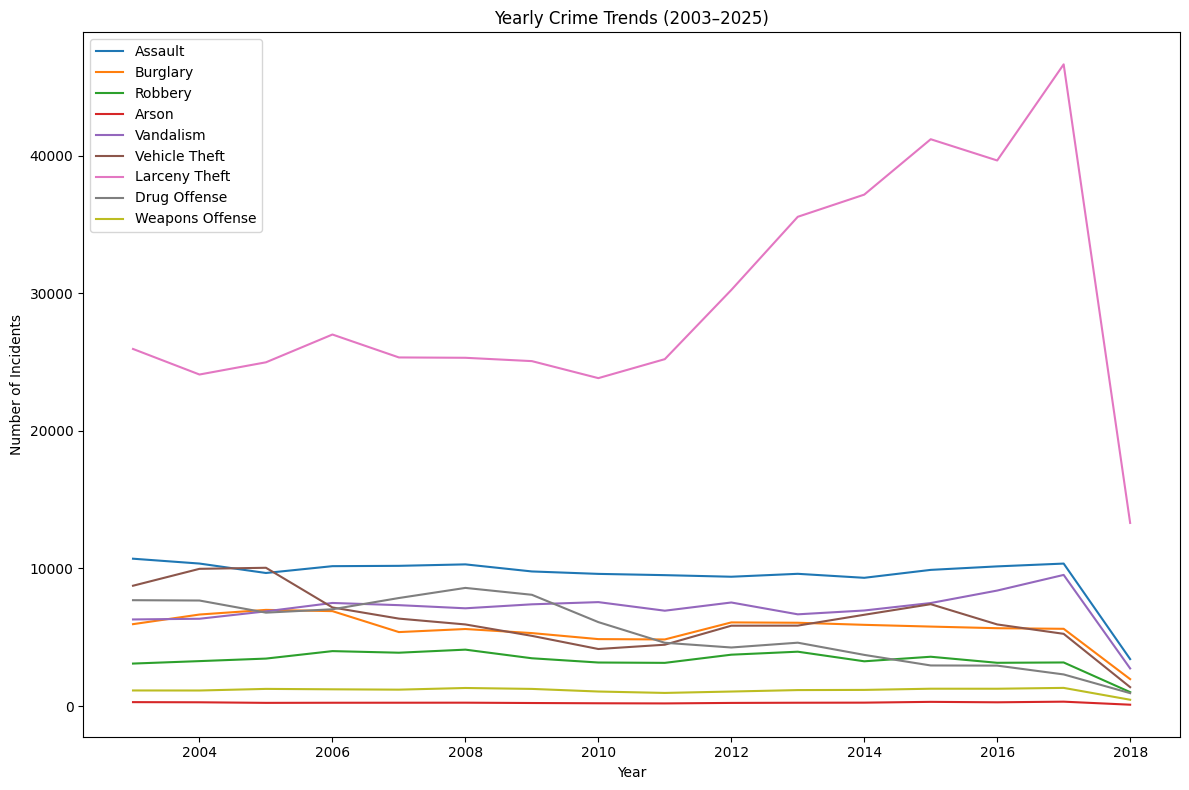

In [11]:
import matplotlib.pyplot as plt

# Ensure year column exists
df_merged["year"] = df_merged["Incident Datetime"].dt.year

# Yearly counts by unified category
yearly_counts = (
    df_merged
    .groupby(["year", "Unified Category"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Keep only your Personal Focus Crimes
focus_crimes = [
    "Assault",
    "Burglary",
    "Robbery",
    "Arson",
    "Vandalism",
    "Vehicle Theft",
    "Larceny Theft",
    "Drug Offense",
    "Weapons Offense"
]

yearly_counts = yearly_counts[focus_crimes]

# Plot
plt.figure(figsize=(12, 8))

for crime in focus_crimes:
    plt.plot(yearly_counts.index, yearly_counts[crime], label=crime)

plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.title("Yearly Crime Trends (2003–2025)")
plt.legend()
plt.tight_layout()
plt.show()


### Step 2.7: Think back on your work in this long and epic run of exercises.

> **Exercise 2.4**: Reflect on your work
>
> * What assumptions did you have to make during this merge?
>   * I had to assume that similarly named categories (e.g., “VEHICLE THEFT” and “Motor Vehicle Theft”) represent the same underlying behavior and that category definitions did not meaningfully change over time.
> * Which of your Personal Focus Crimes are you most/least confident about? Why?
>   * I am most confident about direct matches like Assault, Burglary, and Robbery, and least confident about Drug Offense and Weapons Offense because those categories may have been split, merged, or affected by enforcement changes.
> * If someone used your merged dataset without reading your documentation, what mistakes might they make?
>   * Someone using the merged dataset without reading the documentation might assume categories are perfectly consistent across years and miss structural breaks around 2018 or policy-driven shifts in classification.
> * How does this experience connect to the "dirty data" concept from the Richardson *et al.* reading in Week 1?
>   * This process illustrates the “dirty data” concept because the data reflects institutional decisions about labeling and enforcement, meaning measurement choices—not just real crime—shape the patterns we observe.

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> The reflection should be your own thinking. This is where you practice the critical data science reasoning that separates good analysts from people who just run code.
</div>

**Uncle Sune Rants**: This run of exercises and mini exercises in part 2 migth feel frustrating and difficult. If yes, that's awesome! That's the point. You're getting stronger, smarter, and ready for the real world.

In the real world, you almost never get perfectly clean, perfectly formatted data handed to you on a silver platter. The ability to wrangle messy, inconsistent data into a usable form is one of the most valuable skills in data science. 

## Part 3: Visualizing patterns in the data

Visualizing data is a powerful technique that helps us exploit the human eye and make complex patterns easier to identify. 

Let's use our new mega dataset to look for interesting patterns in the big crime-data. Only consider your Personal Focus Crimes (see Exercise 2.2 above). We'll be generating lots of plots, remember to add good axes, use subplots, pack the plots closely, etc.

* **Hint**: You may use this exercise as an extra validation of the personal focus crimes, and I won't be mad if you go back to Exercise 2.2/2.3 and update your list after having done this exercise.

> **Exercise 3.1**: More temporal patterns
>
> Last time we plotted the development over time (how each of the focus crimes changed over time, year-by-year). Today we'll start by looking at the developments across the months, weekdays, and across the 24 hours of the day. 
>
> * *Yearly trends*. Redo the plots from last week with the new dataset. Do you see anything that surprises you?
> * *Weekly patterns*. Basically, we'll forget about the yearly variation and just count up what happens during each weekday (Monday, Tuesday, ...). 
> * *The months*. We can also check if some months are worse by counting up number of crimes in Jan, Feb, ..., Dec. Did you see any surprises there?
> * *The 24 hour cycle*. We can also forget about weekday and simply count up the number of each crime-type that occurs in the dataset from midnight to 1am, 1am - 2am ... and so on. Again: Give me a couple of comments on what you see. 
> * *Hours of the week*. But by looking at just 24 hours, we may be missing some important trends that can be modulated by week-day, so let's also check out the 168 hours of the week. So let's see the number of each crime-type Monday night from midnight to 1am, Monday night from 1am-2am - all the way to Sunday night from 11pm to midnight.
>    * What does this plot tell you about the limitations of your "24 hour cycle" plot from above.
>    * For some of the crime-types with lots of data, try taking your binning to the 5-minute level. What does that show you? 

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> It's OK to ask your LLM for help with creating these plots, <b>but try on your own first</b>. Use the LLM as a kind of TA to help you get your code to work. Don't just ask for answers and pre-written code. By actually doing the counting and slicing yourself, you'll start to get a feel for how to work with temporal data in pandas. That's a key part of becoming a data whisperer.
</div>

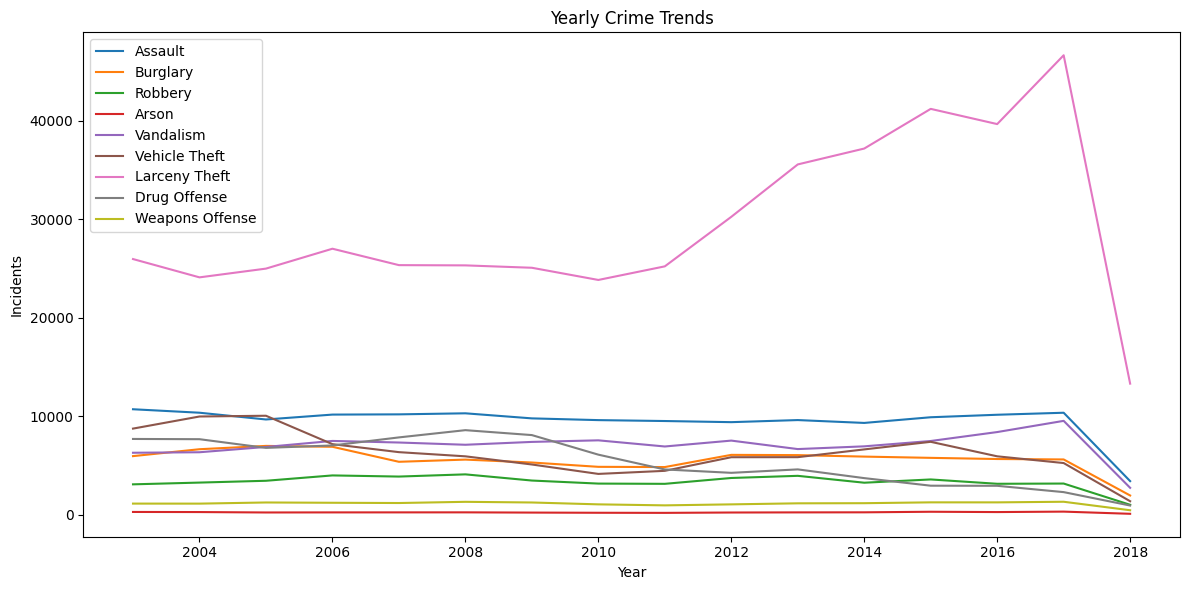

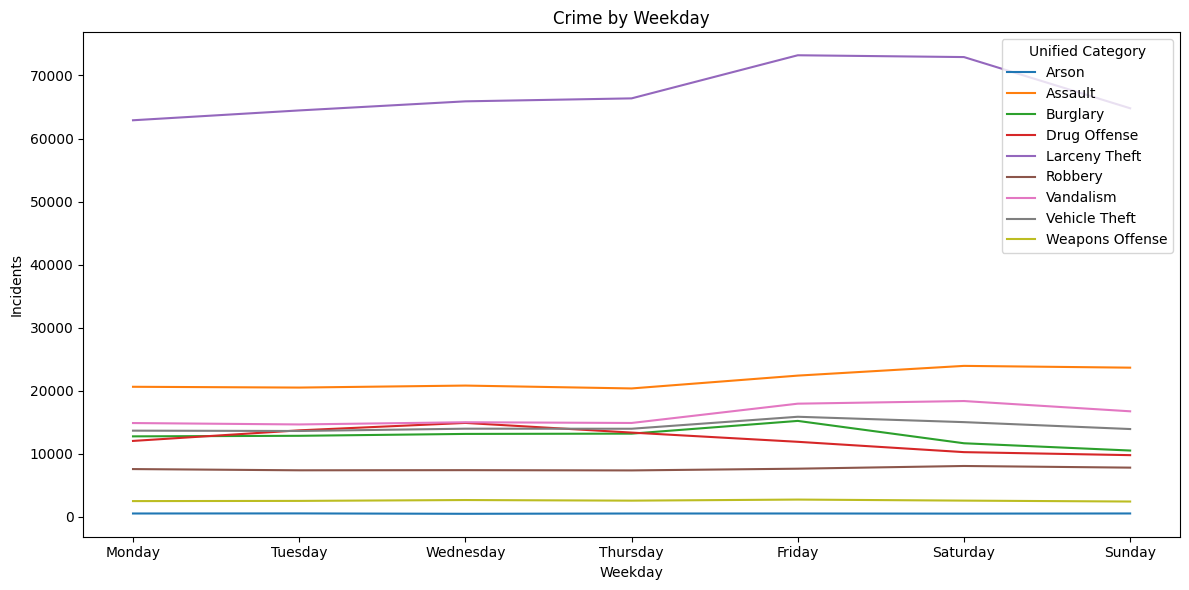

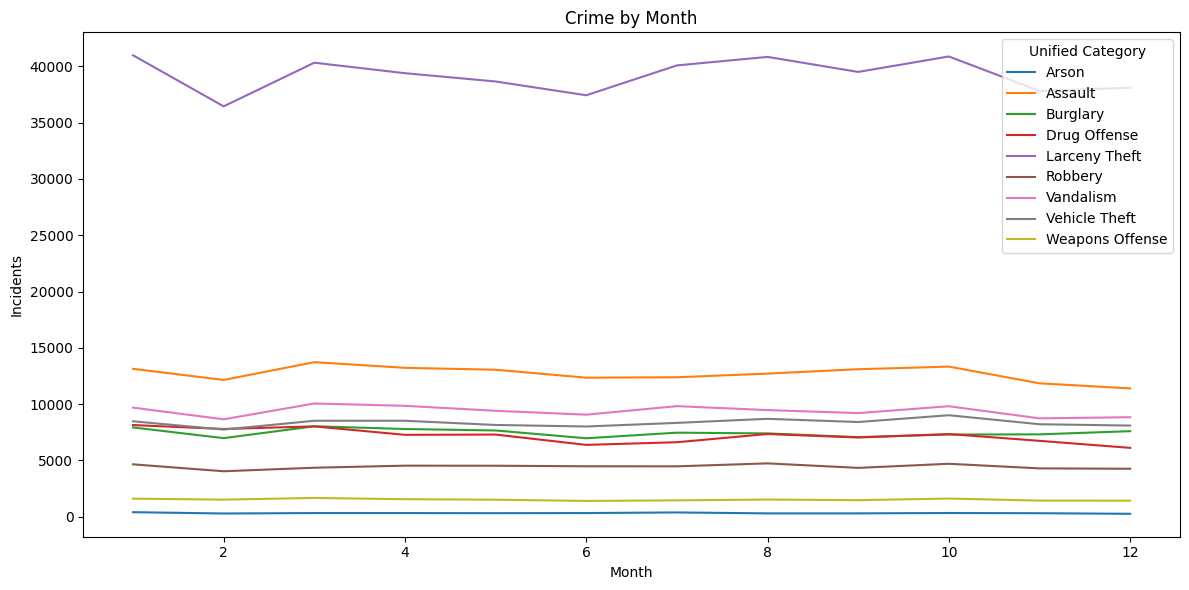

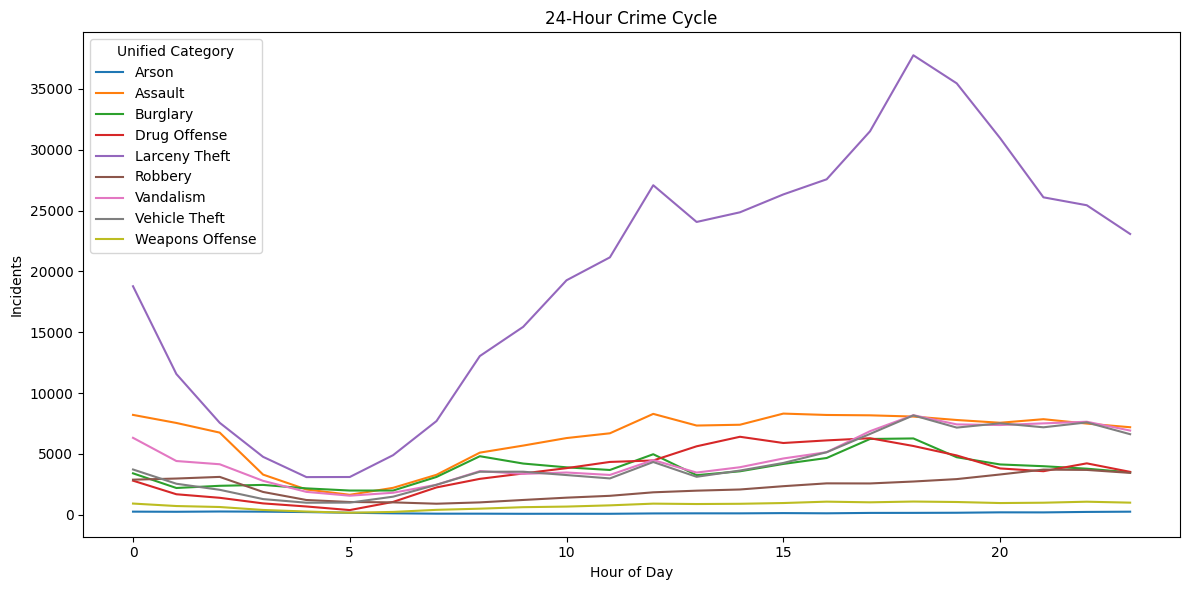

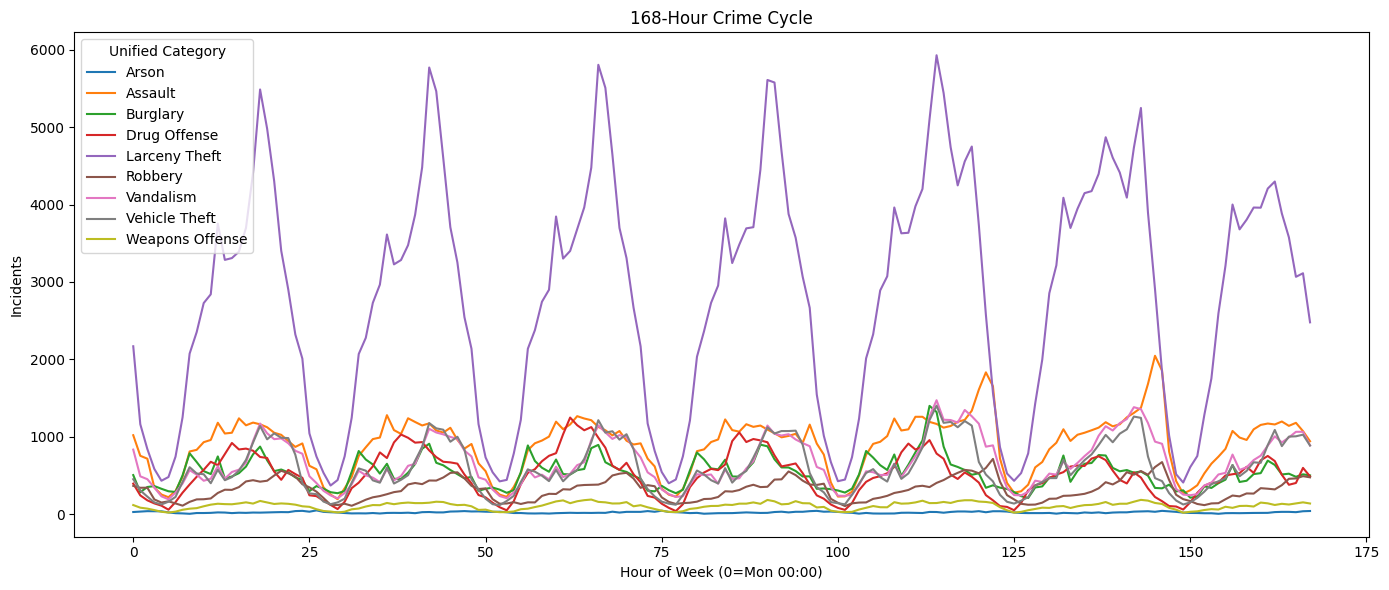

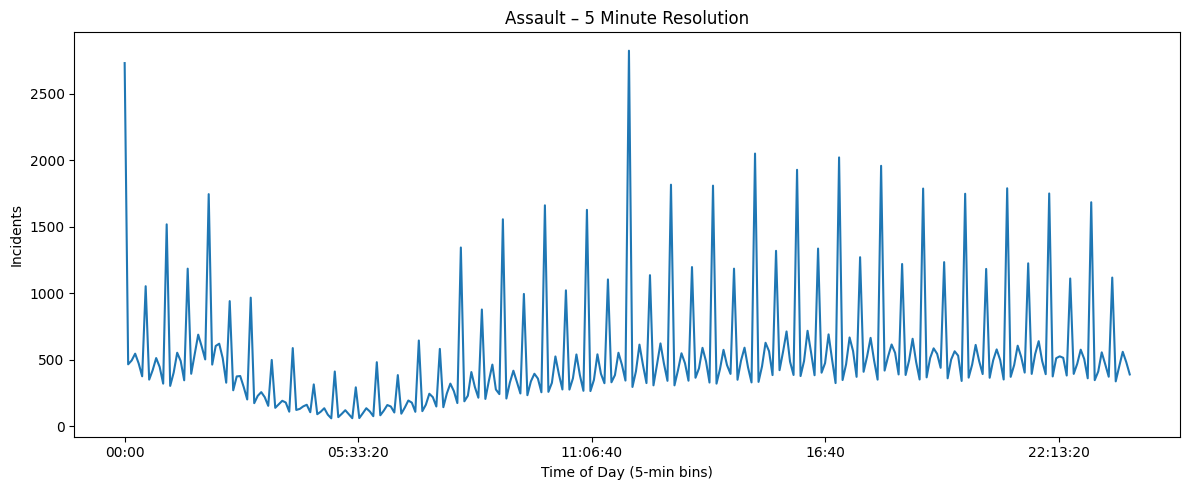

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime features exist
df_merged["year"] = df_merged["Incident Datetime"].dt.year
df_merged["month"] = df_merged["Incident Datetime"].dt.month
df_merged["weekday"] = df_merged["Incident Datetime"].dt.day_name()
df_merged["hour"] = df_merged["Incident Datetime"].dt.hour
df_merged["hour_of_week"] = (
    df_merged["Incident Datetime"].dt.weekday * 24
    + df_merged["Incident Datetime"].dt.hour
)

focus_crimes = [
    "Assault",
    "Burglary",
    "Robbery",
    "Arson",
    "Vandalism",
    "Vehicle Theft",
    "Larceny Theft",
    "Drug Offense",
    "Weapons Offense"
]

#  Yearly trends
yearly = (
    df_merged[df_merged["Unified Category"].isin(focus_crimes)]
    .groupby(["year", "Unified Category"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
for crime in focus_crimes:
    if crime in yearly.columns:
        plt.plot(yearly.index, yearly[crime], label=crime)

plt.xlabel("Year")
plt.ylabel("Incidents")
plt.title("Yearly Crime Trends")
plt.legend()
plt.tight_layout()
plt.show()

#  Weekly patternsq
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday",
                 "Friday", "Saturday", "Sunday"]

weekly = (
    df_merged[df_merged["Unified Category"].isin(focus_crimes)]
    .groupby(["weekday", "Unified Category"])
    .size()
    .unstack(fill_value=0)
    .reindex(weekday_order)
)

weekly.plot(figsize=(12, 6))
plt.xlabel("Weekday")
plt.ylabel("Incidents")
plt.title("Crime by Weekday")
plt.tight_layout()
plt.show()

#  Monthly patterns
monthly = (
    df_merged[df_merged["Unified Category"].isin(focus_crimes)]
    .groupby(["month", "Unified Category"])
    .size()
    .unstack(fill_value=0)
)

monthly.plot(figsize=(12, 6))
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.title("Crime by Month")
plt.tight_layout()
plt.show()

# 24-hour cycle
hourly = (
    df_merged[df_merged["Unified Category"].isin(focus_crimes)]
    .groupby(["hour", "Unified Category"])
    .size()
    .unstack(fill_value=0)
)

hourly.plot(figsize=(12, 6))
plt.xlabel("Hour of Day")
plt.ylabel("Incidents")
plt.title("24-Hour Crime Cycle")
plt.tight_layout()
plt.show()

# 168 hours of week
hour_week = (
    df_merged[df_merged["Unified Category"].isin(focus_crimes)]
    .groupby(["hour_of_week", "Unified Category"])
    .size()
    .unstack(fill_value=0)
)

hour_week.plot(figsize=(14, 6))
plt.xlabel("Hour of Week (0=Mon 00:00)")
plt.ylabel("Incidents")
plt.title("168-Hour Crime Cycle")
plt.tight_layout()
plt.show()

# 5-minute bins (example for Assault)
df_assault = df_merged[df_merged["Unified Category"] == "Assault"].copy()

df_assault["minute_bin"] = (
    df_assault["Incident Datetime"]
    .dt.floor("5min")
    .dt.time
)

five_min = df_assault.groupby("minute_bin").size()

five_min.plot(figsize=(12, 5))
plt.xlabel("Time of Day (5-min bins)")
plt.ylabel("Incidents")
plt.title("Assault – 5 Minute Resolution")
plt.tight_layout()
plt.show()


## Part 4: Exploring other types of plots for temporal data

We now take a mini-break from barcharts and exploring more ways to plot temporal data.

> **Exercise 4.1**: Other cool ways to plot temporal data
>
> I am going to introduce four different plot-types. Then your job is to choose a part of the crime-data that you care about and plot it using these new ways of visualizing data. I recommend that you choose a different part of the crime-data for each plot-type.
>
> * **Calendar plots**. Get started on calendar plots **[here](https://calplot.readthedocs.io/en/latest/)**. There are other packages for plotting these, those are also OK to use.
> * **Polar bar chart**. Here I want you to plot a 24-hour pattern of some sort — those work really well in radial plots (another name for polar plots) because the day wraps around on itself. You can also try plotting data with patterns from the 168 hours of the week. There's not one super-awesome solution here, you can try using [pure matplotlib](https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html) ... [some examples here](https://www.python-graph-gallery.com/circular-barplot/) or via [plotly](https://plotly.com/python/polar-chart/) (scroll down a bit for the polar barchart).
> * **Time series**. Time series is a key functionality of Pandas. To get started, check out the [pandas time series documentation](https://pandas.pydata.org/docs/user_guide/timeseries.html) and the guide on [plotting with a DatetimeIndex](https://pandas.pydata.org/docs/user_guide/visualization.html#plotting-with-a-datetimeindex). For resampling data to different time frequencies (daily, weekly, monthly), see [DataFrame.resample()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html).
> * **Heatmaps**. A heatmap showing hour-of-day vs day-of-week is a classic way to visualize temporal patterns. This pairs nicely with your 168-hour analysis from Exercise 3.1. Get started with [seaborn.heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html) — you'll need to pivot your data into a matrix first.
> * **Reflection**: What did you learn from using LLMs to solve these visualization challenges?

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> For this exercise, you may use the full power of your LLM! Go nuts and see if you can get these plots working by fully relying on LLM-generated code. This is a deliberate contrast to the previous exercises — afterward, reflect on what was different about this experience.
</div>

**Note**: I added this exercise with fewer hints than usual. Normally, I help you break down the problems into small solvable bits. Since this is an LLM-heavy exercise, I haven't done that. But I encourage you to play with figuring out the steps yourself — and compare your breakdown to what the LLM suggests.

This ties into a bigger picture thing about data science.

*My philosophy for data science is this*: Getting to what you want rarely seems hard once you found your way there, the difficulty comes in breaking down a hard problem into the little steps you need to take to solve your complex problem. In this class, I usually do the breaking down for you and provide you with the steps (that's how you go from nothing to creating complex visualizations of crime-data). But I also want you to learn the breaking-problems-down part. LLMs can help here - they can tell you how to break down problems into smaller bits - but if you don't try yourself, you'll never get good at it. So always create your own breakdown first; then see what the computer thinks.

*My approach is always to think something along these lines*: Even if my task seems impossible, I think: "is there any problem that I ***CAN*** solve that will get me closer to where I want to go?" Once I've solved that part, I'm smarter and I try to think: "Is there a new problem I can solve that'll get me closer knowing what I know now?" And I just keep going. Usually that's enough.

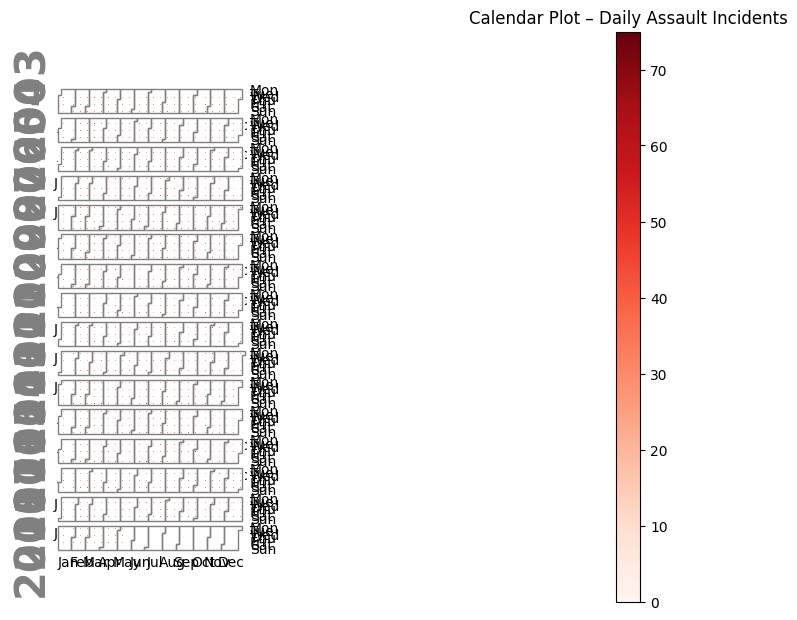

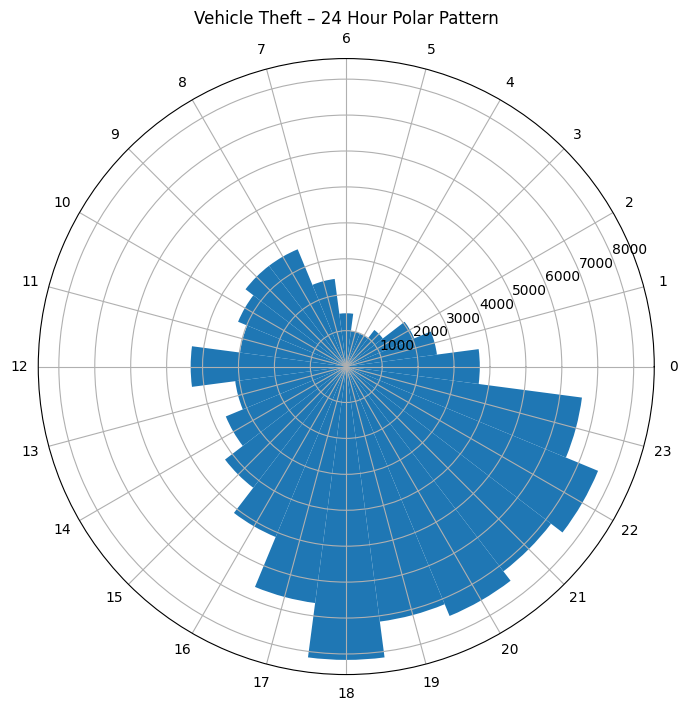

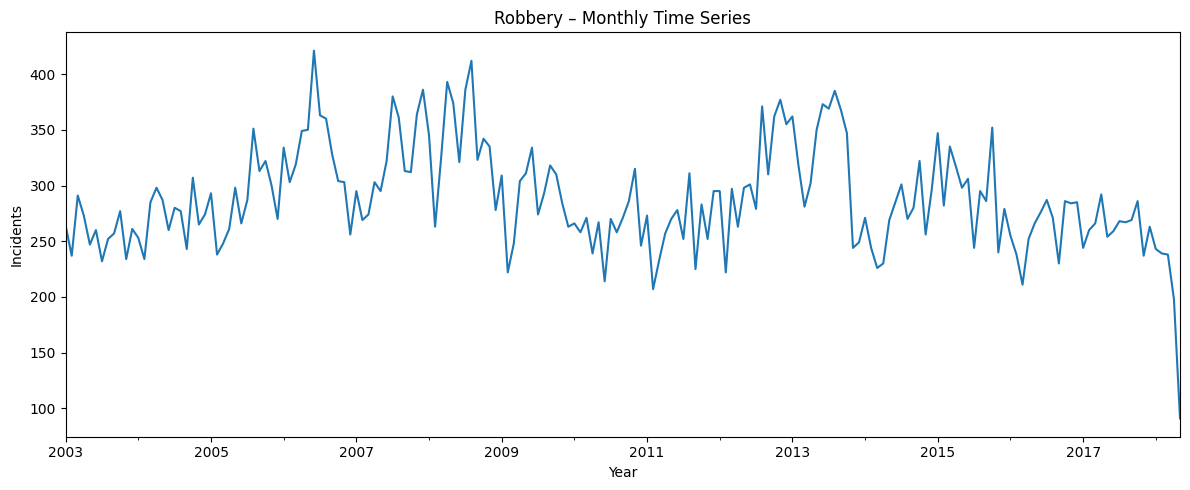

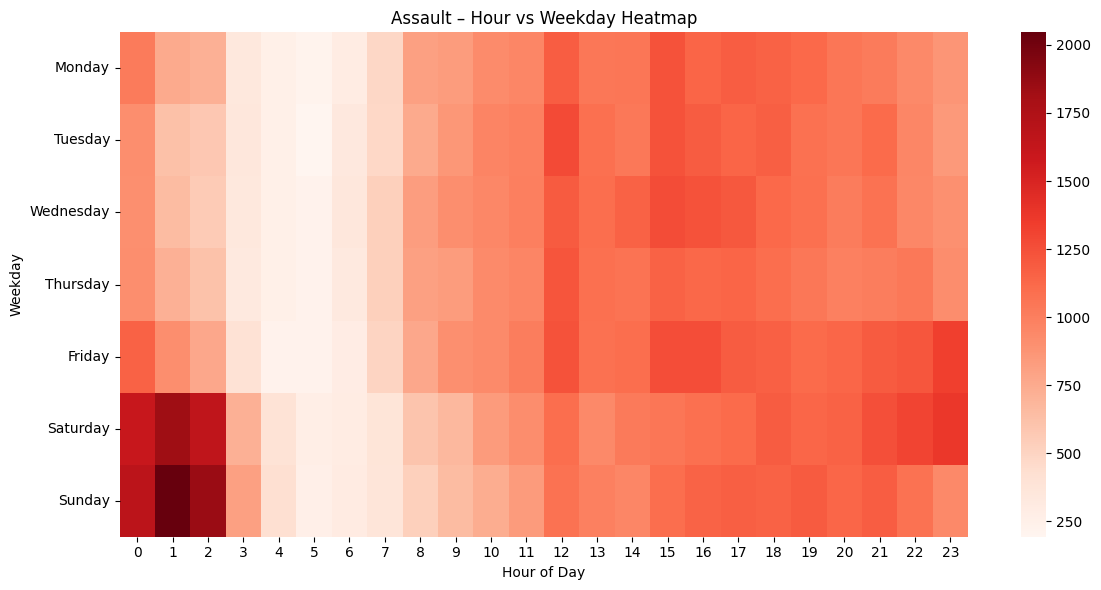

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calplot

# Ensure datetime index for time-series work
df = df_merged.copy()
df = df.dropna(subset=["Incident Datetime"])
df = df.set_index("Incident Datetime")

# 1. Calendar Plot (Assault – daily counts)
assault_daily = (
    df[df["Unified Category"] == "Assault"]
    .resample("D")
    .size()
)

calplot.calplot(
    assault_daily,
    cmap="Reds",
    figsize=(12, 6),
    colorbar=True,
    yearlabel_kws={'fontname': 'sans-serif'}
)

plt.title("Calendar Plot – Daily Assault Incidents")
plt.show()


# 2. Polar Bar Chart (24-hour Vehicle Theft pattern)
vehicle_mask = df["Unified Category"] == "Vehicle Theft"
vehicle_hourly = (
    df.loc[vehicle_mask]
    .groupby(df.loc[vehicle_mask].index.hour)
    .size()
)

hours = np.arange(24)
values = vehicle_hourly.reindex(hours, fill_value=0).values
theta = 2 * np.pi * hours / 24

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.bar(theta, values, width=2*np.pi/24)
ax.set_xticks(theta)
ax.set_xticklabels(hours)
ax.set_title("Vehicle Theft – 24 Hour Polar Pattern")
plt.show()


# 3. Time Series (Monthly Robbery Trend)
robbery_monthly = (
    df[df["Unified Category"] == "Robbery"]
    .resample("ME")
    .size()
)

plt.figure(figsize=(12, 5))
robbery_monthly.plot()
plt.title("Robbery – Monthly Time Series")
plt.xlabel("Year")
plt.ylabel("Incidents")
plt.tight_layout()
plt.show()


# 4. Heatmap (Hour of Day vs Day of Week – Assault)
df_assault = df[df["Unified Category"] == "Assault"].copy()
df_assault["hour"] = df_assault.index.hour
df_assault["weekday"] = df_assault.index.day_name()

heatmap_data = (
    df_assault
    .groupby(["weekday", "hour"])
    .size()
    .unstack(fill_value=0)
)

weekday_order = ["Monday", "Tuesday", "Wednesday",
                 "Thursday", "Friday", "Saturday", "Sunday"]

heatmap_data = heatmap_data.reindex(weekday_order)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Reds")
plt.title("Assault – Hour vs Weekday Heatmap")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()


---

## You've Completed Week 2!

This week you tackled one of the messiest but most important skills in data science: merging imperfect datasets. You now have:

- A unified crime dataset spanning 2003 to the present
- Experience with schema mapping and category matching
- A documented set of Personal Focus Crimes that you can track confidently over time
- New visualization techniques (calendar plots, polar charts, time series)

**Key takeaways:**
- Real-world data is messy. Categories change, formats differ, and documentation is often missing.
- The assumptions you make during data cleaning directly affect what conclusions you can draw.
- Validation is crucial — always check that your merged data makes sense at the boundaries.
- Understanding *why* data looks the way it does is just as important as knowing *how* to process it.

If you want to go further:
- Explore spatial patterns in your merged dataset — which neighborhoods show the most change over 20 years? Do any neighborhoods have different patterns than the city as a whole?
- Try different category mappings and see how they affect your conclusions
- Look for "structural breaks" — points where the data changes in ways that might reflect policy changes, not actual crime changes
- Compare your Personal Focus Crimes list with a classmate's — did you make different choices? Why?